# Creating and excecuting MDF models

This is a quick introduction to building MDF graphs and using them in different scenarios.

1. **[Create a Model containing a Graph](#h1)**
2. **[Generate a graph image from the model](#h2)**
3. **[Execute the graph & print the output values](#h3)**


## 1. Create a [Model](https://mdf.readthedocs.io/en/latest/api/Specification.html#model) containing a [Graph](https://mdf.readthedocs.io/en/latest/api/Specification.html#graph) <a class="anchor" id="h1"></a>


In [1]:
from modeci_mdf.mdf import *

# Create a model containing one graph
mod = Model(id="AB")
mod_graph = Graph(id="ab_example")
mod.graphs.append(mod_graph)



### 1.1 Create the first [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [2]:
# Create a node
a_node = Node(id="A", metadata={"color": "0 .8 0"})

# Add a parameter with a specific value
a_node.parameters.append(Parameter(id="level", value=1.0))

# Add an output port
a_node.output_ports.append(OutputPort(id="output", value = "level"))

# Add node to the graph
mod_graph.nodes.append(a_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level



### 1.2 Create another [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [3]:
b_node = Node(id="B", metadata={"color": ".8 0 0"})
mod_graph.nodes.append(b_node)

# Add an input port
b_node.input_ports.append(InputPort(id="input"))

# Add some parameters
b_node.parameters.append(Parameter(id="slope", value=1.2))
b_node.parameters.append(Parameter(id="intercept", value=3))


# Add a parameter which used the internal parameter as well as the value from the input
p1 = Parameter(
    id="linear_func",
    value="input * slope + intercept",
)
b_node.parameters.append(p1)

# Add an output port
b_node.output_ports.append(OutputPort(id="output", value="linear_func"))


### 1.3 Create an  [Edge](https://mdf.readthedocs.io/en/latest/api/Specification.html#edge) between the [Nodes](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [4]:
# This helper method just adds an edge connecting the first output port of 
# the pre node to the first input port of the post node
from modeci_mdf.utils import simple_connect

e1 = simple_connect(a_node, b_node, mod_graph)

# Print the current structure
print(mod_graph.to_yaml())


ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                slope:
                    value: 1.2
                intercept:
                    value: 3
                linear_func:
                    value: input * slope + intercept
            output_ports:
                output:
                    value: linear_func
    edges:
        edge_A_B:
            sender: A
            receiver: B
            sender_port: output
            receiver_port: input



## 2. Generate a graph image from the model <a class="anchor" id="h2"></a>

We will use a method on the model to generate an image representing the structure of the graph.


Converting MDF graph: ab_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 .8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
    Edge: edge_A_B connects A to B
Written graph image to: AB.png


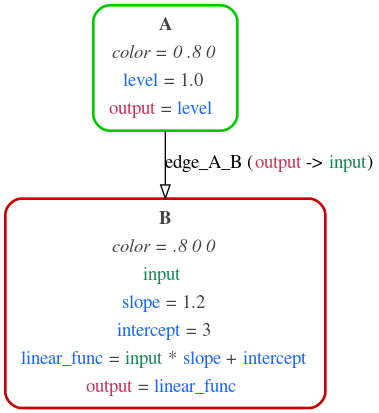

In [5]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="AB"
    )

from IPython.display import Image
Image(filename="AB.png")

## 3. Execute the graph & print the output values <a class="anchor" id="h3"></a>

The Graph is converted to an EvaluableGraph, which can be used to evaluate the current state of the graph's parameters. 

### 3.1 Execute the graph with the current parameter values 

In [6]:
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)


Init graph: ab_example
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A: 1
Output of B: 4.2


### 3.2 Change a value to a Numpy array & execute the graph again

In [7]:
import numpy as np 
a_node.get_parameter('level').value = np.array([[1,2],[3,4]])

eg.evaluate()

print('Output of A:\n%s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B:\n%s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)

Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.2 5.4]
 [6.6 7.8]]


## Modification

### Simple calculator

This example will create a basic calculator using MDF which can perform
1. addition
2. subtraction
3. multiplication
4. division

**input node**

In [8]:
from modeci_mdf.mdf import *

# Create a model containing one graph
mod = Model(id="calculator")
mod_graph = Graph(id="calculator")
mod.graphs.append(mod_graph)

In [9]:
input_node = Node(id="input_values")

# Add parameter
input_node.parameters.append(Parameter(id="input_x"))
input_node.parameters.append(Parameter(id="input_y"))

# Add an output port
input_node.output_ports.append(OutputPort(id="x", value="input_x"))
input_node.output_ports.append(OutputPort(id="y", value="input_y"))
mod_graph.nodes.append(input_node)



1. **ADDITION**

In [10]:
# Create a node
addition_node = Node(id="Addition")

# creating input node
addition_node.input_ports.append(Parameter(id="x"))
addition_node.input_ports.append(Parameter(id="y"))

# Add state variable
addition_node.parameters.append(Parameter(id="net_addition",value = "net_addition + x + y"))

# Add an output port
addition_node.output_ports.append(OutputPort(id="output", value = "x + y"))

# Add node to the graph
mod_graph.nodes.append(addition_node)

In [11]:

# adding edges

e1 = Edge(id="x-value-add",
        sender="input_values",
        receiver="Addition",
        sender_port="x",
        receiver_port="x")

e2 = Edge(id="y-value-add",
        sender="input_values",
        receiver="Addition",
        sender_port="y",
        receiver_port="y")

In [12]:
mod_graph.edges.append(e1)
mod_graph.edges.append(e2)

2. **SUBTRACTION**

In [13]:
# Create a node
subtraction_node = Node(id="Subtraction")

# creating input node
subtraction_node.input_ports.append(Parameter(id="x"))
subtraction_node.input_ports.append(Parameter(id="y"))

# Add state variable
subtraction_node.parameters.append(Parameter(id="net_subtraction",value = "net_subtraction + x - y"))

# Add an output port
subtraction_node.output_ports.append(OutputPort(id="output", value = "x - y"))

# Add node to the graph
mod_graph.nodes.append(subtraction_node)

In [14]:
# adding edges

e3 = Edge(id="x-value-sub",
        sender="input_values",
        receiver="Subtraction",
        sender_port="x",
        receiver_port="x")

e4 = Edge(id="y-value-sub",
        sender="input_values",
        receiver="Subtraction",
        sender_port="y",
        receiver_port="y")

In [15]:
mod_graph.edges.append(e3)
mod_graph.edges.append(e4)

3. **MULTIPLICATION**

In [16]:
# Create a node
multiplication_node = Node(id="Multiplication")

# creating input node
multiplication_node.input_ports.append(Parameter(id="x"))
multiplication_node.input_ports.append(Parameter(id="y"))

# Add state variable
multiplication_node.parameters.append(Parameter(id="net_multiplication",value = "net_multiplication + x * y"))

# Add an output port
multiplication_node.output_ports.append(OutputPort(id="output", value = "x * y"))

# Add node to the graph
mod_graph.nodes.append(multiplication_node)

In [17]:
# adding edges

e5 = Edge(id="x-value-multi",
        sender="input_values",
        receiver="Multiplication",
        sender_port="x",
        receiver_port="x")

e6 = Edge(id="y-value-multi",
        sender="input_values",
        receiver="Multiplication",
        sender_port="y",
        receiver_port="y")

In [18]:
mod_graph.edges.append(e5)
mod_graph.edges.append(e6)

4. **DIVISION**

In [19]:
# Create a node
division_node = Node(id="Division")

# creating input node
division_node.input_ports.append(Parameter(id="x"))
division_node.input_ports.append(Parameter(id="y"))

# Add state variable
division_node.parameters.append(Parameter(id="net_division",value = "net_division + x / y"))

# Add an output port
division_node.output_ports.append(OutputPort(id="output", value = "x / y"))

# Add node to the graph
mod_graph.nodes.append(division_node)

In [20]:
# adding edges

e7 = Edge(id="x-value-div",
        sender="input_values",
        receiver="Division",
        sender_port="x",
        receiver_port="x")

e8 = Edge(id="y-value-div",
        sender="input_values",
        receiver="Division",
        sender_port="y",
        receiver_port="y")

In [21]:
mod_graph.edges.append(e7)
mod_graph.edges.append(e8)

**PRINTING IN YAML FORMAT**

In [22]:
print(mod_graph.to_yaml())


calculator:
    nodes:
        input_values:
            parameters:
                input_x: {}
                input_y: {}
            output_ports:
                x:
                    value: input_x
                y:
                    value: input_y
        Addition:
            input_ports:
                x: {}
                y: {}
            parameters:
                net_addition:
                    value: net_addition + x + y
            output_ports:
                output:
                    value: x + y
        Subtraction:
            input_ports:
                x: {}
                y: {}
            parameters:
                net_subtraction:
                    value: net_subtraction + x - y
            output_ports:
                output:
                    value: x - y
        Multiplication:
            input_ports:
                x: {}
                y: {}
            parameters:
                net_multiplication:
                    value: net_mult

Converting MDF graph: calculator to graphviz (level: 2, format: png)
    Node: input_values
    Node: Addition
    Node: Subtraction
    Node: Multiplication
    Node: Division
    Edge: x-value-add connects input_values to Addition
    Edge: y-value-add connects input_values to Addition
    Edge: x-value-sub connects input_values to Subtraction
    Edge: y-value-sub connects input_values to Subtraction
    Edge: x-value-multi connects input_values to Multiplication
    Edge: y-value-multi connects input_values to Multiplication
    Edge: x-value-div connects input_values to Division
    Edge: y-value-div connects input_values to Division
Written graph image to: Calculator.png


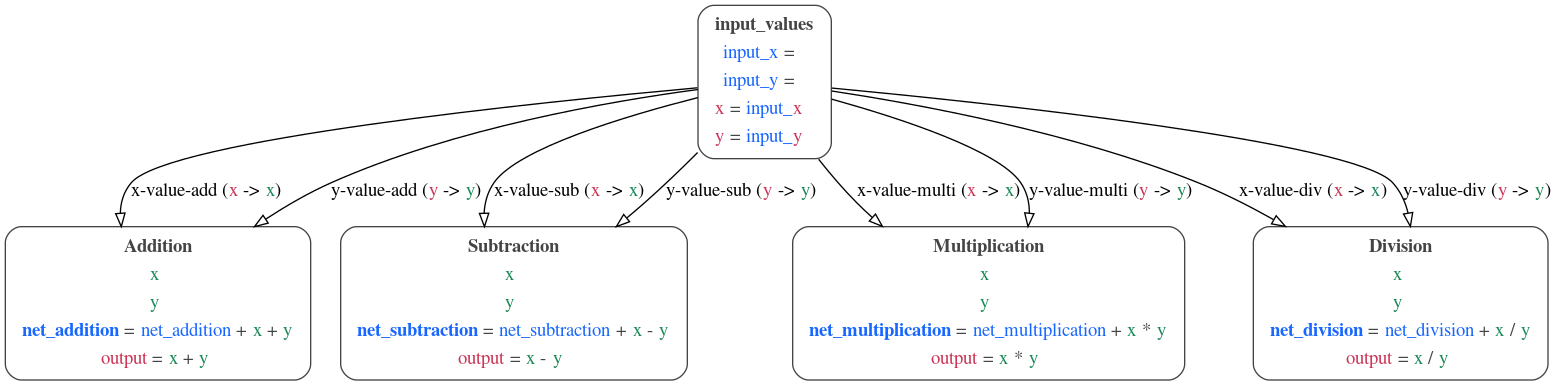

In [23]:

mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        filename_root="Calculator"
    )

from IPython.display import Image
Image(filename="Calculator.png")

In [24]:
from modeci_mdf.execution_engine import EvaluableGraph
import numpy as np

eg = EvaluableGraph(mod_graph, verbose=False)
input_node.get_parameter('input_x').value = 6
input_node.get_parameter('input_y').value = 2

eg.evaluate()

#print input value
print('input x is: %s'%eg.enodes["input_values"].evaluable_outputs["x"].curr_value)
print('input y is: %s'%eg.enodes["input_values"].evaluable_outputs["y"].curr_value)

#print output value
print('Output of addition: %s'%eg.enodes["Addition"].evaluable_outputs["output"].curr_value)
print('Output of subtraction: %s'%eg.enodes["Subtraction"].evaluable_outputs["output"].curr_value)
print('Output of multiplication: %s'%eg.enodes["Multiplication"].evaluable_outputs["output"].curr_value)
print('Output of division: %s'%eg.enodes["Division"].evaluable_outputs["output"].curr_value)

#print state-variables parameters
print('output of state-variable at Addition: %s'%eg.enodes["Addition"].evaluable_parameters["net_addition"].curr_value)
print('output of state-variable at Subtraction: %s'%eg.enodes["Subtraction"].evaluable_parameters["net_subtraction"].curr_value)
print('output of state-variable at Multiplication: %s'%eg.enodes["Multiplication"].evaluable_parameters["net_multiplication"].curr_value)
print('output of state-variable at Division: %s'%eg.enodes["Division"].evaluable_parameters["net_division"].curr_value)


Init graph: calculator
Evaluating graph: calculator, root nodes: ['input_values'], with array format numpy
input x is: 6
input y is: 2
Output of addition: 8
Output of subtraction: 4
Output of multiplication: 12
Output of division: 3
output of state-variable at Addition: 8
output of state-variable at Subtraction: 4
output of state-variable at Multiplication: 12
output of state-variable at Division: 3


### check state variable values after re-exectution

In [25]:
input_node.get_parameter('input_x').value = 3
input_node.get_parameter('input_y').value = 3

#re-evaluating
eg.evaluate()
print('output of state-variable at Addition: %s'%eg.enodes["Addition"].evaluable_parameters["net_addition"].curr_value)
print('output of state-variable at Subtraction: %s'%eg.enodes["Subtraction"].evaluable_parameters["net_subtraction"].curr_value)
print('output of state-variable at Multiplication: %s'%eg.enodes["Multiplication"].evaluable_parameters["net_multiplication"].curr_value)
print('output of state-variable at Division: %s'%eg.enodes["Division"].evaluable_parameters["net_division"].curr_value)

Evaluating graph: calculator, root nodes: ['input_values'], with array format numpy
output of state-variable at Addition: 14
output of state-variable at Subtraction: 4
output of state-variable at Multiplication: 21
output of state-variable at Division: 4
